In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings
import spacy
from tqdm.notebook import tqdm_notebook

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sakshi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sakshi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sakshi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sakshi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\sakshi\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sakshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt 

In [2]:
# load the dataset
tweets=pd.read_csv('Elon_musk.csv',encoding='Latin-1')
tweets.drop(['Unnamed: 0'],inplace=True,axis=1)
tweets.rename({'Text':'Tweets'},axis=1,inplace=True)
tweets

,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


## Data Exploration
### Number of words

In [3]:
tweets['word_count'] = tweets['Tweets'].apply(lambda x: len(str(x).split(" ")))
tweets[['Tweets','word_count']].head()

,Tweets,word_count
0,@kunalb11 Im an alien,4
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13
2,@joerogan @Spotify Great interview!,4
3,@gtera27 Doge is underestimated,4
4,@teslacn Congratulations Tesla China for amazi...,17


### Number of characters

In [4]:
tweets['char_count'] = tweets['Tweets'].str.len() ## this also includes spaces
tweets[['Tweets','char_count']].head()

,Tweets,char_count
0,@kunalb11 Im an alien,22
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,82
2,@joerogan @Spotify Great interview!,35
3,@gtera27 Doge is underestimated,31
4,@teslacn Congratulations Tesla China for amazi...,104


### Average word length

In [5]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

tweets['avg_word'] = tweets['Tweets'].apply(lambda x: avg_word(x))
tweets[['Tweets','avg_word']].head()

,Tweets,avg_word
0,@kunalb11 Im an alien,4.750000
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,5.384615
2,@joerogan @Spotify Great interview!,8.000000
3,@gtera27 Doge is underestimated,7.000000
4,@teslacn Congratulations Tesla China for amazi...,5.176471


### Number of stopwords

In [6]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

tweets['stopwords'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x in stop]))
tweets[['Tweets','stopwords']].head()

,Tweets,stopwords
0,@kunalb11 Im an alien,1
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,4
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,1
4,@teslacn Congratulations Tesla China for amazi...,5


### Number of Special characters

In [7]:
tweets['hashtags'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets[['Tweets','hashtags']].head()

,Tweets,hashtags
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


### Number of numerics

In [8]:
tweets['numerics'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
tweets[['Tweets','numerics']].head()

,Tweets,numerics
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


### Number of uppercase words

In [9]:
tweets['upper'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
tweets[['Tweets','upper']].head()

,Tweets,upper
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,1
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


In [10]:
tweets.drop(['numerics','hashtags','stopwords','avg_word','char_count','word_count','upper'],axis=1,inplace=True)

### Number of Rare words

In [11]:
freq = pd.Series(' '.join(tweets['Tweets']).split()).value_counts()[-10:]
freq

N3                         1
lab                        1
(N1                        1
detection                  1
Lab                        1
https://t.co/K77wXQ11yt    1
dicey                      1
accurate,                  1
thinks                     1
28                         1
dtype: int64

### Percentage of links attached in the tweets

In [12]:
tweets.Tweets.str.contains('https://').value_counts() / len(tweets)

False    0.678339
True     0.321661
Name: Tweets, dtype: float64

### Percentage of users tagged in the tweets

In [13]:
tweets.Tweets.str.contains('@').value_counts() / len(tweets)

True     0.83942
False    0.16058
Name: Tweets, dtype: float64

### Total number of tweets available in the Dataframe

In [14]:
# Total tweets
print('Total tweets this period:', len(tweets.index), '\n')

Total tweets this period: 1999 



### Spellings correction

In [15]:
from textblob import TextBlob
tweets['Tweets'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                               @kunalb11 Im an alien
1    @ID_AA_Carmack May tracing on Cyberpunk with H...
2                   @joerogan @Notify Great interview!
3                       @gtera27 One is underestimated
4    @teslacn Congratulations Cela China for amazin...
Name: Tweets, dtype: object

### N-grams
N-grams are a combination of multiple words used together. Ngrams with N=1 are called unigrams. Similarly, bigrams (N=2), trigrams (N=3) and so on can also be used.

In [16]:
TextBlob(tweets['Tweets'][3]).ngrams(1)

[WordList(['gtera27']),
 WordList(['Doge']),
 WordList(['is']),
 WordList(['underestimated'])]

In [17]:
TextBlob(tweets['Tweets'][2]).ngrams(2)

[WordList(['joerogan', 'Spotify']),
 WordList(['Spotify', 'Great']),
 WordList(['Great', 'interview'])]

In [18]:
TextBlob(tweets['Tweets'][4]).ngrams(3)

[WordList(['teslacn', 'Congratulations', 'Tesla']),
 WordList(['Congratulations', 'Tesla', 'China']),
 WordList(['Tesla', 'China', 'for']),
 WordList(['China', 'for', 'amazing']),
 WordList(['for', 'amazing', 'execution']),
 WordList(['amazing', 'execution', 'last']),
 WordList(['execution', 'last', 'year']),
 WordList(['last', 'year', 'Now']),
 WordList(['year', 'Now', 'on']),
 WordList(['Now', 'on', 'to']),
 WordList(['on', 'to', 'the']),
 WordList(['to', 'the', 'next']),
 WordList(['the', 'next', 'for']),
 WordList(['next', 'for', 'even']),
 WordList(['for', 'even', 'more'])]

### Things on his mind
Lets see what elon musk thinks about different topics using word tokenization.

In [19]:
from nltk import word_tokenize
tokens = tweets.Tweets.map(word_tokenize)

def what_does_elon_think_about(x):
    x_l = x.lower()
    x_t = x.title()
    return tweets.loc[tokens.map(lambda sent: x_l in sent or x_t in sent).values]

In [20]:
what_does_elon_think_about('life').Tweets.values.tolist()

['@flcnhvy Tesla is responsible for 2/3 of all the personal &amp; professional pain in my life combined. But it was worth it.',
 'Life, the Universe and Everything https://t.co/1ZCzInfc4u',
 'This is a life leader launch, so more risk than normal https://t.co/EtFP9IELrf',
 '@Astronomiaum Life in glass domes at first. Eventually, terraformed to support life, like Earth.',
 '@peterrhague It\x92s designed to make life multiplanetary, otherwise extreme overkill for mere Earth sector activity!\x85 https://t.co/yjLTT8pEEu',
 '@teslaownersSV @toadmeister I\x92ve spent more than half my life in California &amp; love the state. But, frankly, I think\x85 https://t.co/s5xouoedjT',
 '@bamtheteslaman1 @cleantechnica Doesn\x92t seem to be any life in this solar system. Maybe under the ice of Europa or\x85 https://t.co/izk0v9Gi47',
 'Speedrunning Factorio in real life \x85',
 'Story of my life',
 '@teslavibes Couldn\x92t agree more \x97 major software improvements are already in place to extend its l

In [21]:
what_does_elon_think_about('meme').Tweets.values.tolist()

['I am become meme,\nDestroyer of shorts']

## Data Visualization

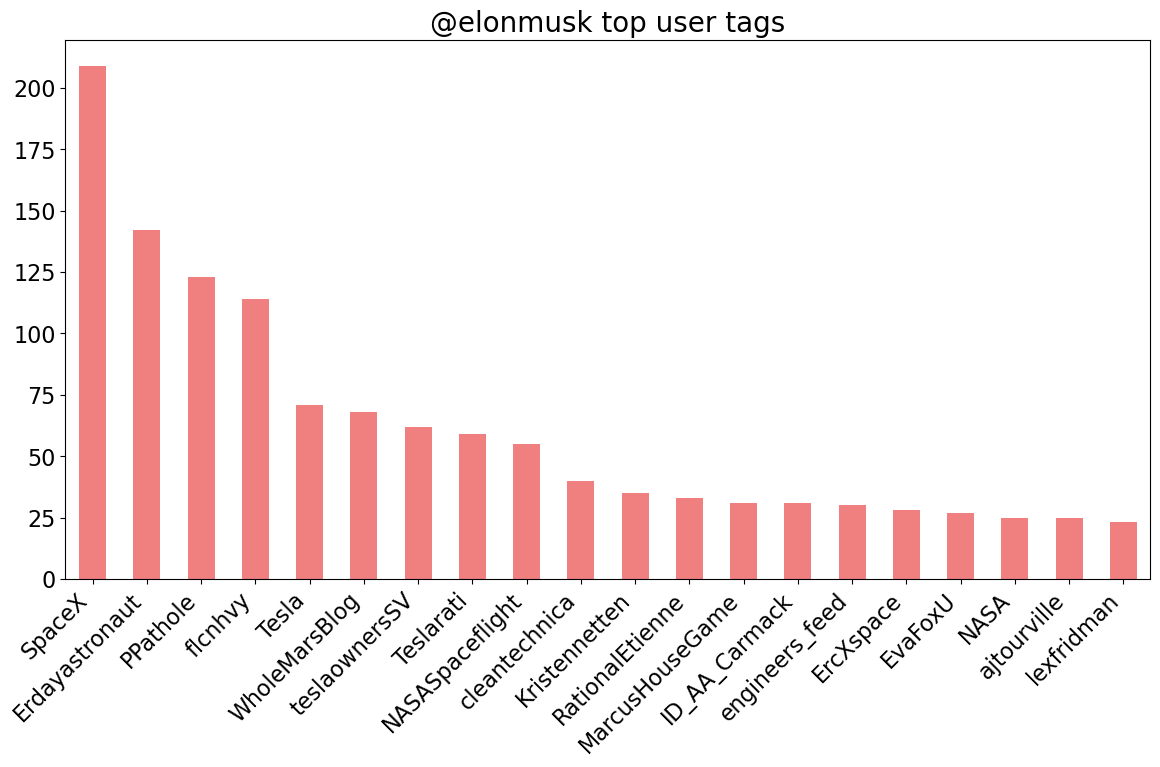

In [22]:
import itertools

c = list(
itertools.chain(
    *tweets.Tweets.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ") 
                            if '@' in handle.replace(":", "")]).tolist())
)

pd.Series(c).value_counts().head(20).plot.bar(
    figsize=(14, 7), fontsize=16, color='lightcoral'
)
plt.gca().set_title('@elonmusk top user tags', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha='right', fontsize=16)
pass

## Basic text preprocessing

### Collecting all the Tweets for Textual Pre-Processing

In [23]:
tweets=[Text.strip() for Text in tweets.Tweets] # remove both the leading and the trailing characters
tweets=[Text for Text in tweets if Text] # removes empty strings, because they are considered in Python as False
tweets[0:10]

['@kunalb11 I\x92m an alien',
 '@ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it?',
 '@joerogan @Spotify Great interview!',
 '@gtera27 Doge is underestimated',
 '@teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!!',
 'Happy New Year of the Ox! https://t.co/9WFKMYu2oj',
 'Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM',
 '@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :)',
 '@flcnhvy @anonyx10 Indeed! Tweets definitely do not represent real-world time allocation.',
 'The most entertaining outcome is the most likely']

### Combining all the Tweets into Text

In [24]:
# Joining the list into one string/text
tweets_text=' '.join(tweets)
tweets_text[:1000]

'@kunalb11 I\x92m an alien @ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it? @joerogan @Spotify Great interview! @gtera27 Doge is underestimated @teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!! Happy New Year of the Ox! https://t.co/9WFKMYu2oj Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM @OwenSparks_ @flcnhvy @anonyx10 Haha thanks :) @flcnhvy @anonyx10 Indeed! Tweets definitely do not represent real-world time allocation. The most entertaining outcome is the most likely @GiveDirectly Just sent some Just agree to do Clubhouse with @kanyewest https://t.co/3rWE9uHSTS @geoffkeighley @UnrealEngine It\x92s getting real Bought some Dogecoin for lil X, so he can be a toddler hodler @JoshManMode He definitely has issues, but the sentencing seems a bit high @freewalletorg Thanks for fixing @freewalletorg Please unlock my account @AstroJordy <U+0001F923><U

### Using TweetTokenizer to remove all the Twitter Username Handles

In [25]:
# remove Twitter username handles from a given twitter text. (Removes @usernames)
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)
tweets_tokens=tknzr.tokenize(tweets_text)
print(tweets_tokens[:100])

['I', '\x92', 'm', 'an', 'alien', 'Ray', 'tracing', 'on', 'Cyberpunk', 'with', 'HDR', 'is', 'next-level', '.', 'Have', 'you', 'tried', 'it', '?', 'Great', 'interview', '!', 'Doge', 'is', 'underestimated', 'Congratulations', 'Tesla', 'China', 'for', 'amazing', 'execution', 'last', 'year', '.', 'Now', 'on', 'to', 'the', 'next', 'for', 'even', 'more', '!', '!', 'Happy', 'New', 'Year', 'of', 'the', 'Ox', '!', 'https://t.co/9WFKMYu2oj', 'Frodo', 'was', 'the', 'underdoge', ',', 'All', 'thought', 'he', 'would', 'fail', ',', 'Himself', 'most', 'of', 'all', '.', 'https://t.co/zGxJFDzzrM', 'Haha', 'thanks', ':)', 'Indeed', '!', 'Tweets', 'definitely', 'do', 'not', 'represent', 'real-world', 'time', 'allocation', '.', 'The', 'most', 'entertaining', 'outcome', 'is', 'the', 'most', 'likely', 'Just', 'sent', 'some', 'Just', 'agree', 'to', 'do', 'Clubhouse', 'with']


### Joining all the tokenized words into Text/Strings

In [26]:
# Again Joining the list into one string/text
tweets_tokens_text=' '.join(tweets_tokens)
tweets_tokens_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is next-level . Have you tried it ? Great interview ! Doge is underestimated Congratulations Tesla China for amazing execution last year . Now on to the next for even more ! ! Happy New Year of the Ox ! https://t.co/9WFKMYu2oj Frodo was the underdoge , All thought he would fail , Himself most of all . https://t.co/zGxJFDzzrM Haha thanks :) Indeed ! Tweets definitely do not represent real-world time allocation . The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with https://t.co/3rWE9uHSTS It \x92 s getting real Bought some Dogecoin for lil X , so he can be a toddler hodler He definitely has issues , but the sentencing seems a bit high Thanks for fixing Please unlock my account <U+0001F923> <U+0001F923> This is true power haha https://t.co/Fc9uhQSd7O Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT : NASA has selected Falcon Heavy to 

### Removing all the Punctuations fromt the Combined Text

In [27]:
# Remove Punctuations 
no_punc_text=tweets_tokens_text.translate(str.maketrans('','',string.punctuation))
no_punc_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is nextlevel  Have you tried it  Great interview  Doge is underestimated Congratulations Tesla China for amazing execution last year  Now on to the next for even more   Happy New Year of the Ox  httpstco9WFKMYu2oj Frodo was the underdoge  All thought he would fail  Himself most of all  httpstcozGxJFDzzrM Haha thanks  Indeed  Tweets definitely do not represent realworld time allocation  The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with httpstco3rWE9uHSTS It \x92 s getting real Bought some Dogecoin for lil X  so he can be a toddler hodler He definitely has issues  but the sentencing seems a bit high Thanks for fixing Please unlock my account U0001F923 U0001F923 This is true power haha httpstcoFc9uhQSd7O Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT  NASA has selected Falcon Heavy to launch the first two elements of the lunar Ga

### Removing all the URLs from the text

In [28]:
# remove https or url within text
import re
no_url_text=re.sub(r'http\S+', '', no_punc_text)
no_url_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is nextlevel  Have you tried it  Great interview  Doge is underestimated Congratulations Tesla China for amazing execution last year  Now on to the next for even more   Happy New Year of the Ox   Frodo was the underdoge  All thought he would fail  Himself most of all   Haha thanks  Indeed  Tweets definitely do not represent realworld time allocation  The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with  It \x92 s getting real Bought some Dogecoin for lil X  so he can be a toddler hodler He definitely has issues  but the sentencing seems a bit high Thanks for fixing Please unlock my account U0001F923 U0001F923 This is true power haha  Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT  NASA has selected Falcon Heavy to launch the first two elements of the lunar Gateway together on one mission   Yes Once we can predict cash flow reason

### Again Tokenizing Text into individual words for further pre-processing

In [29]:
import nltk.data
from nltk.tokenize import word_tokenize
text_tokens=word_tokenize(no_url_text)
print(text_tokens[:100])

['I', '\x92', 'm', 'an', 'alien', 'Ray', 'tracing', 'on', 'Cyberpunk', 'with', 'HDR', 'is', 'nextlevel', 'Have', 'you', 'tried', 'it', 'Great', 'interview', 'Doge', 'is', 'underestimated', 'Congratulations', 'Tesla', 'China', 'for', 'amazing', 'execution', 'last', 'year', 'Now', 'on', 'to', 'the', 'next', 'for', 'even', 'more', 'Happy', 'New', 'Year', 'of', 'the', 'Ox', 'Frodo', 'was', 'the', 'underdoge', 'All', 'thought', 'he', 'would', 'fail', 'Himself', 'most', 'of', 'all', 'Haha', 'thanks', 'Indeed', 'Tweets', 'definitely', 'do', 'not', 'represent', 'realworld', 'time', 'allocation', 'The', 'most', 'entertaining', 'outcome', 'is', 'the', 'most', 'likely', 'Just', 'sent', 'some', 'Just', 'agree', 'to', 'do', 'Clubhouse', 'with', 'It', '\x92', 's', 'getting', 'real', 'Bought', 'some', 'Dogecoin', 'for', 'lil', 'X', 'so', 'he', 'can', 'be']


In [30]:
# Tokens count
len(text_tokens)

17847

### Removing all the stopwords from the text

In [31]:
# Remove Stopwords
from nltk.corpus import stopwords
my_stop_words=stopwords.words('english')

sw_list = ['\x92','rt','ye','yeah','haha','Yes','U0001F923','I','U0001F3B6','U0001F5A4']
my_stop_words.extend(sw_list)

no_stop_tokens=[word for word in text_tokens if not word in my_stop_words]
print(no_stop_tokens[:100])

['alien', 'Ray', 'tracing', 'Cyberpunk', 'HDR', 'nextlevel', 'Have', 'tried', 'Great', 'interview', 'Doge', 'underestimated', 'Congratulations', 'Tesla', 'China', 'amazing', 'execution', 'last', 'year', 'Now', 'next', 'even', 'Happy', 'New', 'Year', 'Ox', 'Frodo', 'underdoge', 'All', 'thought', 'would', 'fail', 'Himself', 'Haha', 'thanks', 'Indeed', 'Tweets', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'The', 'entertaining', 'outcome', 'likely', 'Just', 'sent', 'Just', 'agree', 'Clubhouse', 'It', 'getting', 'real', 'Bought', 'Dogecoin', 'lil', 'X', 'toddler', 'hodler', 'He', 'definitely', 'issues', 'sentencing', 'seems', 'bit', 'high', 'Thanks', 'fixing', 'Please', 'unlock', 'account', 'This', 'true', 'power', 'Any', 'crypto', 'wallet', 'give', 'private', 'keys', 'avoided', 'costs', 'Your', 'app', 'sucks', 'RT', 'NASA', 'selected', 'Falcon', 'Heavy', 'launch', 'first', 'two', 'elements', 'lunar', 'Gateway', 'together', 'one', 'mission']


### Converting all the text into lowercase

In [32]:
# Making the Text in Lowercase
lower_words=[Text.lower() for Text in no_stop_tokens]
print(lower_words[:100])

['alien', 'ray', 'tracing', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'tried', 'great', 'interview', 'doge', 'underestimated', 'congratulations', 'tesla', 'china', 'amazing', 'execution', 'last', 'year', 'now', 'next', 'even', 'happy', 'new', 'year', 'ox', 'frodo', 'underdoge', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thanks', 'indeed', 'tweets', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'the', 'entertaining', 'outcome', 'likely', 'just', 'sent', 'just', 'agree', 'clubhouse', 'it', 'getting', 'real', 'bought', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definitely', 'issues', 'sentencing', 'seems', 'bit', 'high', 'thanks', 'fixing', 'please', 'unlock', 'account', 'this', 'true', 'power', 'any', 'crypto', 'wallet', 'give', 'private', 'keys', 'avoided', 'costs', 'your', 'app', 'sucks', 'rt', 'nasa', 'selected', 'falcon', 'heavy', 'launch', 'first', 'two', 'elements', 'lunar', 'gateway', 'together', 'one', 'mission']


### Stemming the text using NLTK library

In [33]:
# Stemming 
from nltk.stem import PorterStemmer
ps=PorterStemmer()
stemmed_tokens=[ps.stem(word) for word in lower_words]
print(stemmed_tokens[:100])

['alien', 'ray', 'trace', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'tri', 'great', 'interview', 'doge', 'underestim', 'congratul', 'tesla', 'china', 'amaz', 'execut', 'last', 'year', 'now', 'next', 'even', 'happi', 'new', 'year', 'ox', 'frodo', 'underdog', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thank', 'inde', 'tweet', 'definit', 'repres', 'realworld', 'time', 'alloc', 'the', 'entertain', 'outcom', 'like', 'just', 'sent', 'just', 'agre', 'clubhous', 'it', 'get', 'real', 'bought', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definit', 'issu', 'sentenc', 'seem', 'bit', 'high', 'thank', 'fix', 'pleas', 'unlock', 'account', 'thi', 'true', 'power', 'ani', 'crypto', 'wallet', 'give', 'privat', 'key', 'avoid', 'cost', 'your', 'app', 'suck', 'rt', 'nasa', 'select', 'falcon', 'heavi', 'launch', 'first', 'two', 'element', 'lunar', 'gateway', 'togeth', 'one', 'mission']


### Lemmatization of Text data using Spacy library

In [34]:
# Lemmatization
nlp=spacy.load('en_core_web_sm')
doc=nlp(' '.join(lower_words))
print(doc[:100])

alien ray tracing cyberpunk hdr nextlevel have tried great interview doge underestimated congratulations tesla china amazing execution last year now next even happy new year ox frodo underdoge all thought would fail himself haha thanks indeed tweets definitely represent realworld time allocation the entertaining outcome likely just sent just agree clubhouse it getting real bought dogecoin lil x toddler hodler he definitely issues sentencing seems bit high thanks fixing please unlock account this true power any crypto wallet give private keys avoided costs your app sucks rt nasa selected falcon heavy launch first two elements lunar gateway together one mission


In [35]:
lemmas=[token.lemma_ for token in doc]
print(lemmas[:100])

['alien', 'ray', 'trace', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'try', 'great', 'interview', 'doge', 'underestimate', 'congratulation', 'tesla', 'china', 'amazing', 'execution', 'last', 'year', 'now', 'next', 'even', 'happy', 'new', 'year', 'ox', 'frodo', 'underdoge', 'all', 'think', 'would', 'fail', 'himself', 'haha', 'thank', 'indeed', 'tweet', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'the', 'entertaining', 'outcome', 'likely', 'just', 'send', 'just', 'agree', 'clubhouse', 'it', 'get', 'real', 'buy', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definitely', 'issue', 'sentencing', 'seem', 'bit', 'high', 'thank', 'fix', 'please', 'unlock', 'account', 'this', 'true', 'power', 'any', 'crypto', 'wallet', 'give', 'private', 'key', 'avoid', 'cost', 'your', 'app', 'suck', 'rt', 'nasa', 'select', 'falcon', 'heavy', 'launch', 'first', 'two', 'element', 'lunar', 'gateway', 'together', 'one', 'mission']


In [36]:
clean_tweets=' '.join(lemmas)
clean_tweets[:1000]

'alien ray trace cyberpunk hdr nextlevel have try great interview doge underestimate congratulation tesla china amazing execution last year now next even happy new year ox frodo underdoge all think would fail himself haha thank indeed tweet definitely represent realworld time allocation the entertaining outcome likely just send just agree clubhouse it get real buy dogecoin lil x toddler hodler he definitely issue sentencing seem bit high thank fix please unlock account this true power any crypto wallet give private key avoid cost your app suck rt nasa select falcon heavy launch first two element lunar gateway together one mission once predict cash flow reasonably well starlink ipo starlink staggeringly difficult technical economic endeavor however spacex need pass deep chasm negative cash flow next year low cost per ton carbon sequester net value product make must scalable g it mean price country only difference taxis ship this intend earth may idea apply mars xprize team manage 100 m 

## Generate Word Cloud

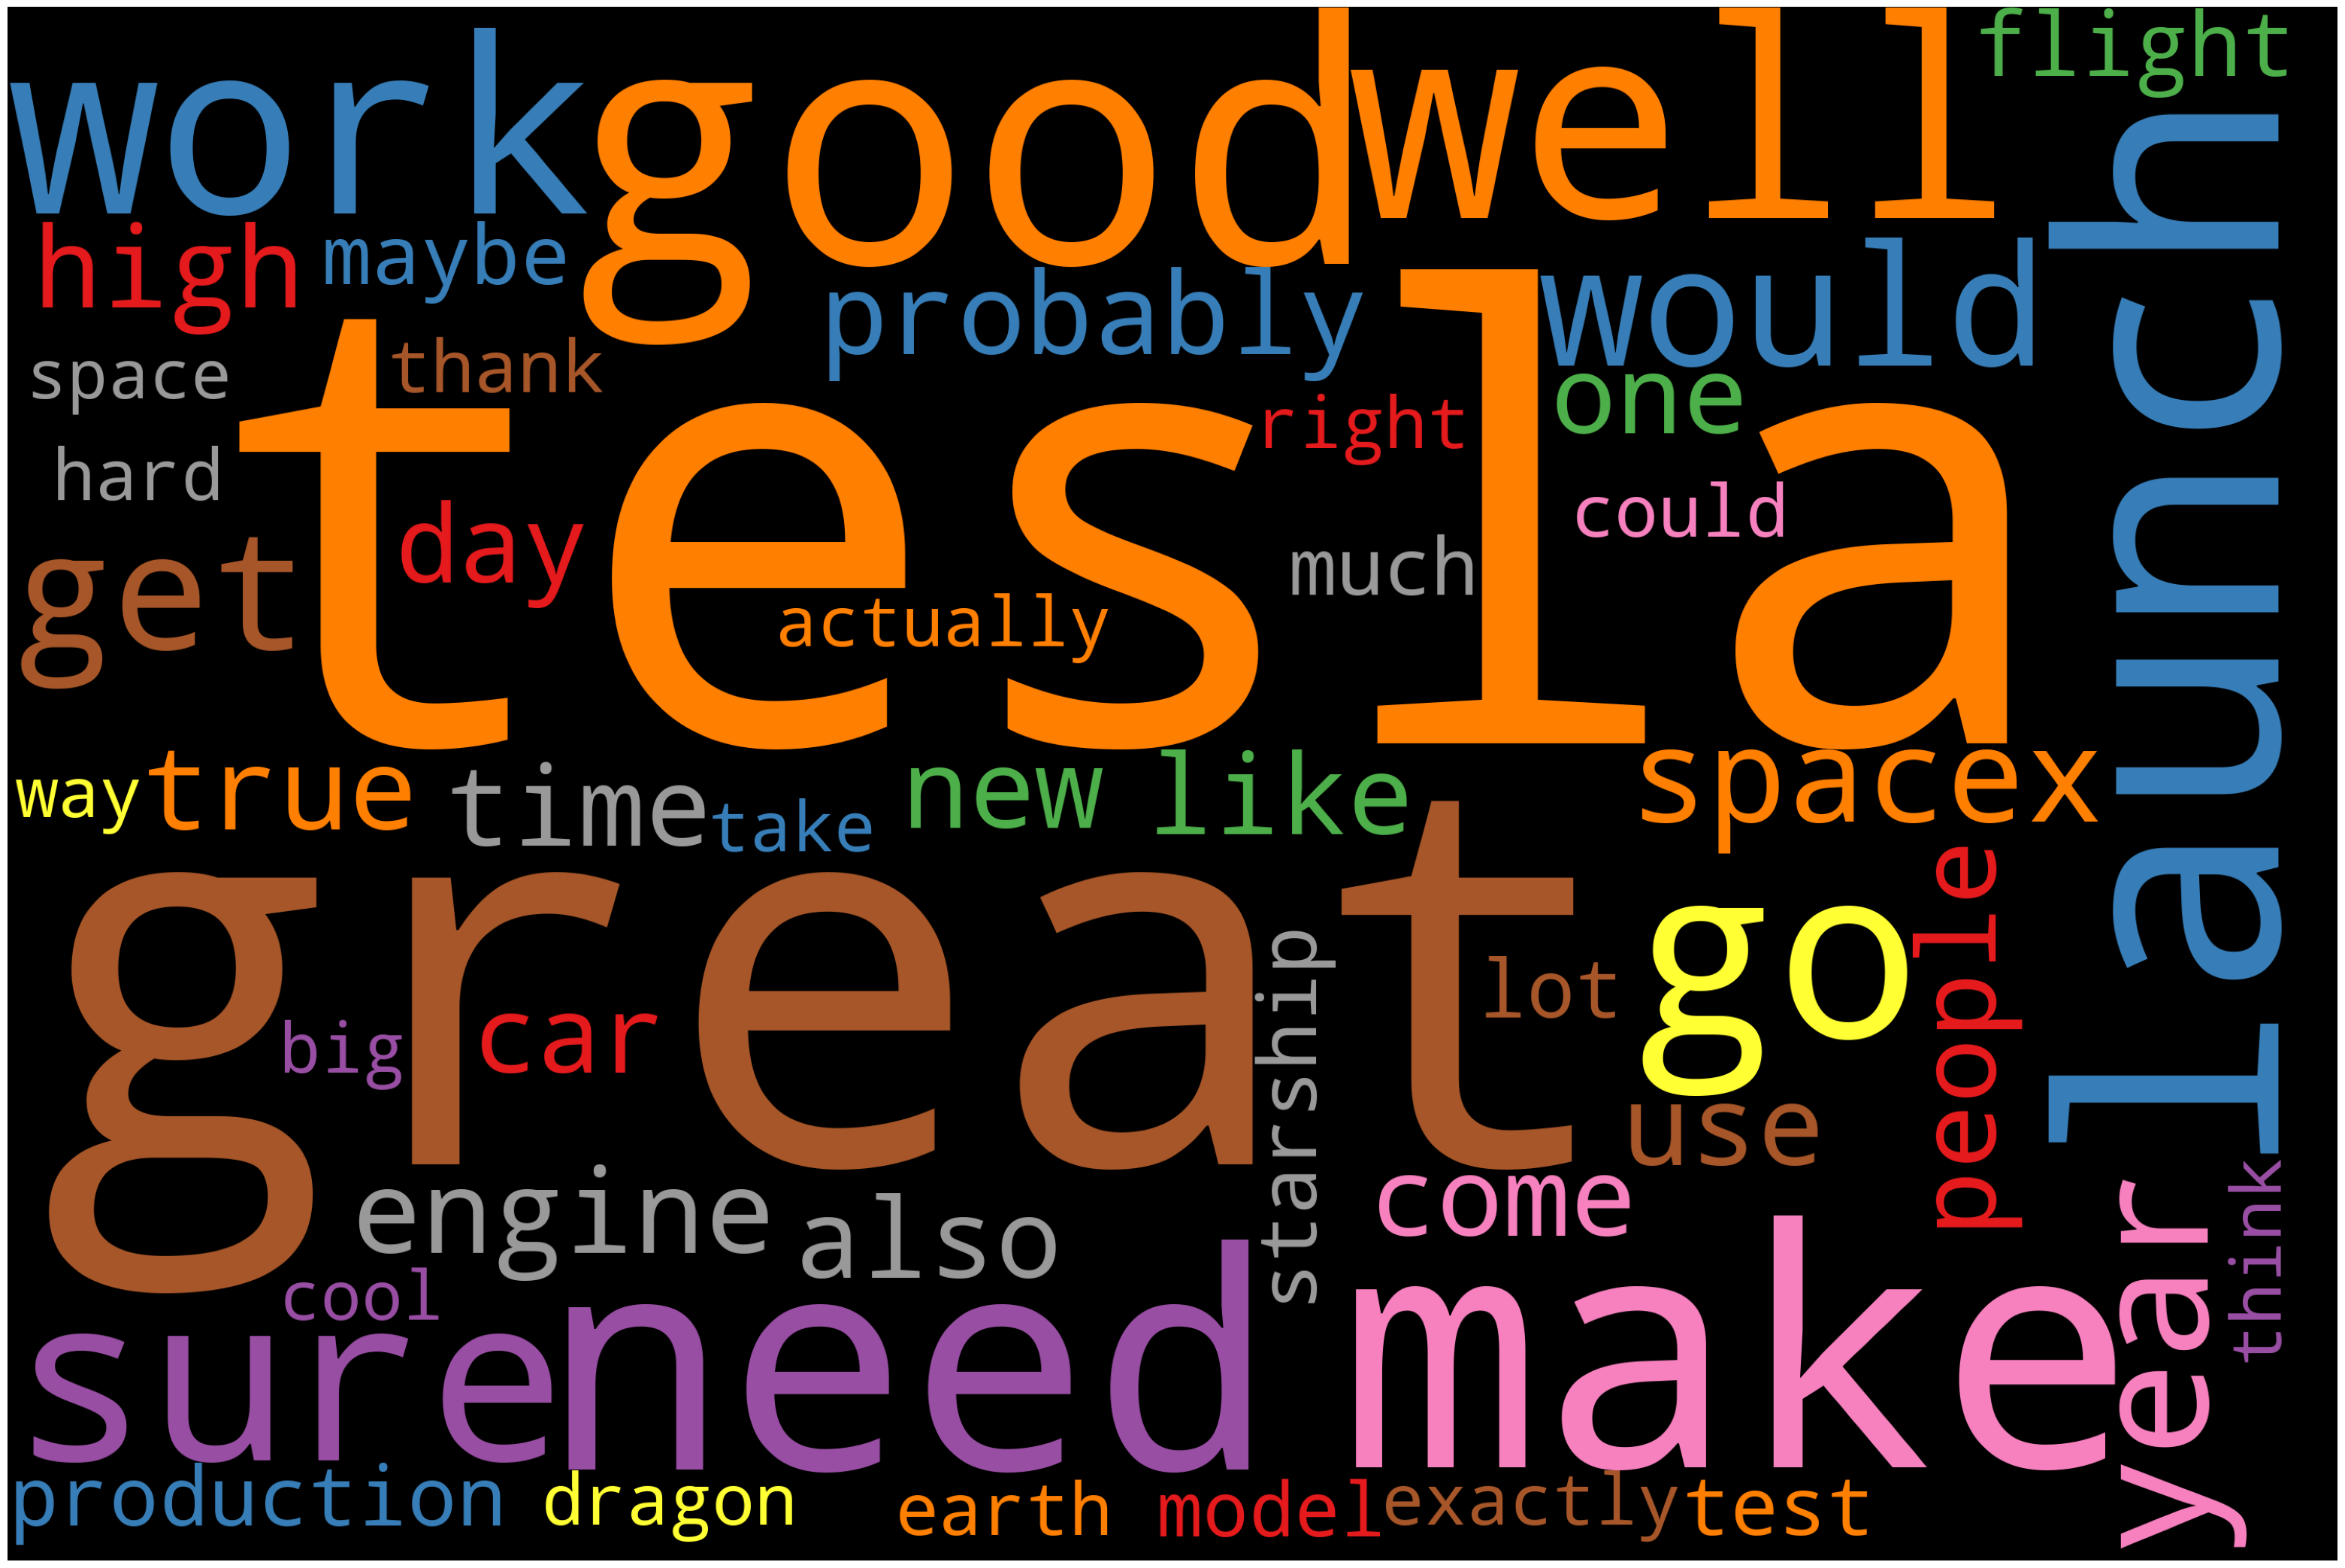

In [37]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40,30))
    plt.imshow(wordcloud)
    plt.axis('off')
    
# Generate Word Cloud

#STOPWORDS.add('pron')
#STOPWORDS.add('rt')
#STOPWORDS.add('yeah')
wordcloud=WordCloud(width=3000,height=2000,background_color='black',max_words=50,
                   colormap='Set1',stopwords=my_stop_words).generate(clean_tweets)
plot_cloud(wordcloud)

## Named Entity Recognition (NER)

In [38]:
# Parts Of Speech (POS) Tagging
nlp=spacy.load('en_core_web_sm')

one_block=clean_tweets[:1000]
doc_block=nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)

In [39]:
for token in doc_block[:50]:
    print(token,token.pos_)  

alien PROPN
ray NOUN
trace NOUN
cyberpunk PROPN
hdr PROPN
nextlevel NOUN
have AUX
try VERB
great ADJ
interview NOUN
doge X
underestimate PROPN
congratulation PROPN
tesla PROPN
china PROPN
amazing ADJ
execution NOUN
last ADJ
year NOUN
now ADV
next ADV
even ADV
happy ADJ
new ADJ
year NOUN
ox NOUN
frodo NOUN
underdoge PROPN
all PRON
think VERB
would AUX
fail VERB
himself PRON
haha PROPN
thank VERB
indeed ADV
tweet NOUN
definitely ADV
represent VERB
realworld PROPN
time NOUN
allocation NOUN
the DET
entertaining ADJ
outcome NOUN
likely ADV
just ADV
send VERB
just ADV
agree VERB


### Filtering out only the nouns and verbs from the Text to Tokens

In [40]:
# Filtering the nouns and verbs only
one_block=clean_tweets
doc_block=nlp(one_block)
nouns_verbs=[token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[100:200])

['booster', 'improve', 'ship', 'booster', 'mass', 'work', 'tonight', 'ðogecoin', 'video', 'people', 'speak', 'image', 'reflect', 'time', 'cost', 'people', 'rain', 'pain', 'let', 'come', 'crypto', 'simplicity', 'genius', 'decade', 'work', 'look', 'note', 'email', 'text', 'lesson', 'learn', 'earth', 'time', 'tell', 'story', 'tesla', 'read', 'kingdom', 'hear', 'name', 'year', 'dogecake', 'thing', 'restaurant', 'hang', 'currency', 'earth', 'scratch', 'destiny', 'franz', 'say', 'ship', 'landing', 'burn', 'solution', 'greate', 'use', 'gas', 'maneuvering', 'rcs', 'thruster', 'seem', 'raptor', 'launch', 'mission', 'collect', 'galaxy', 'explore', 'launch', 'starlink', 'satellite', 'orbit', 'mission', 'pad', '39a', 'deck', 'default', 'engine', 'lever', 'arm', 'shut', 'engine', 'point', 'flameout', 'risk', 'start', 'engine', 'shut', 'need', 'land', 'become', 'destroyer', 'happen', 'sandstorm', 'masterpiece', 'dumb', 'time', 'try', 'pull', 'method']


### Counting all the nouns and verbs present in the Tokens of words

In [41]:
# Counting the noun & verb tokens
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()

X=cv.fit_transform(nouns_verbs)
sum_words=X.sum(axis=0)

words_freq=[(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df=pd.DataFrame(words_freq)
wd_df.columns=['word','count']
wd_df[0:10] # viewing top ten results

,word,count
0,launch,64
1,make,64
2,year,49
3,work,48
4,go,47
5,need,42
6,come,39
7,get,38
8,day,38
9,time,37


### Visualizing the Result of Top 10 nouns and verbs most frequently present in the tweets

<AxesSubplot:title={'center':'Top 10 nouns and verbs'}, xlabel='word'>

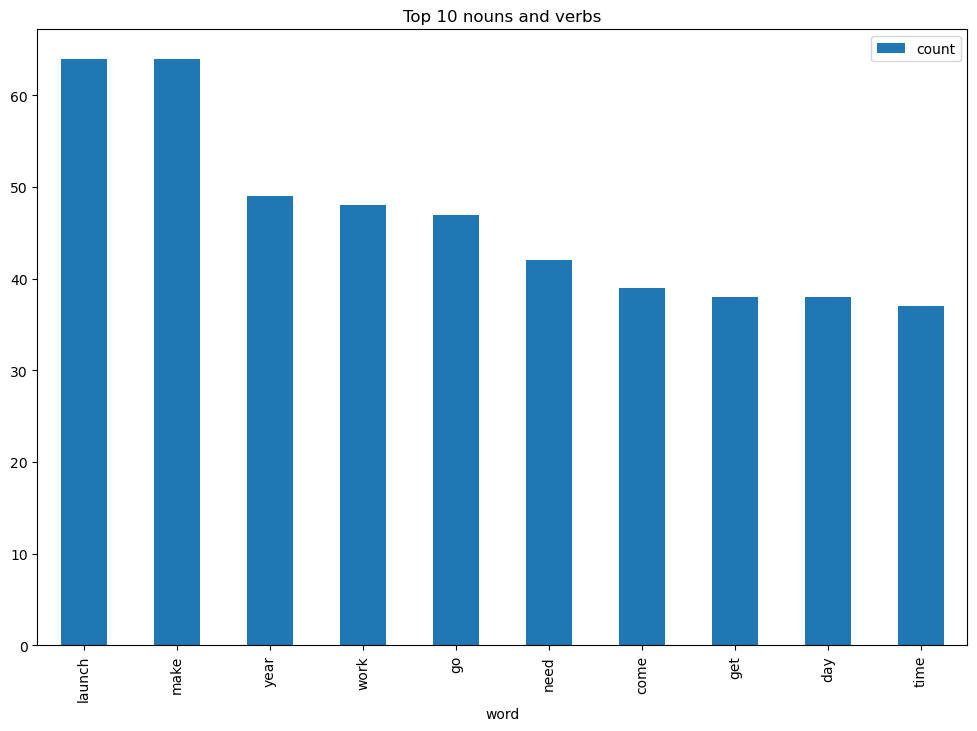

In [42]:
# Visualizing results (Barchart for top 10 nouns + verbs)
wd_df[0:10].plot.bar(x='word',figsize=(12,8),title='Top 10 nouns and verbs')